최하연의 브랜치

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
from math import pi
from pandas.plotting import parallel_coordinates

# 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'  # '맑은 고딕'이 설치되어 있을 경우
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 부호 깨짐 방지

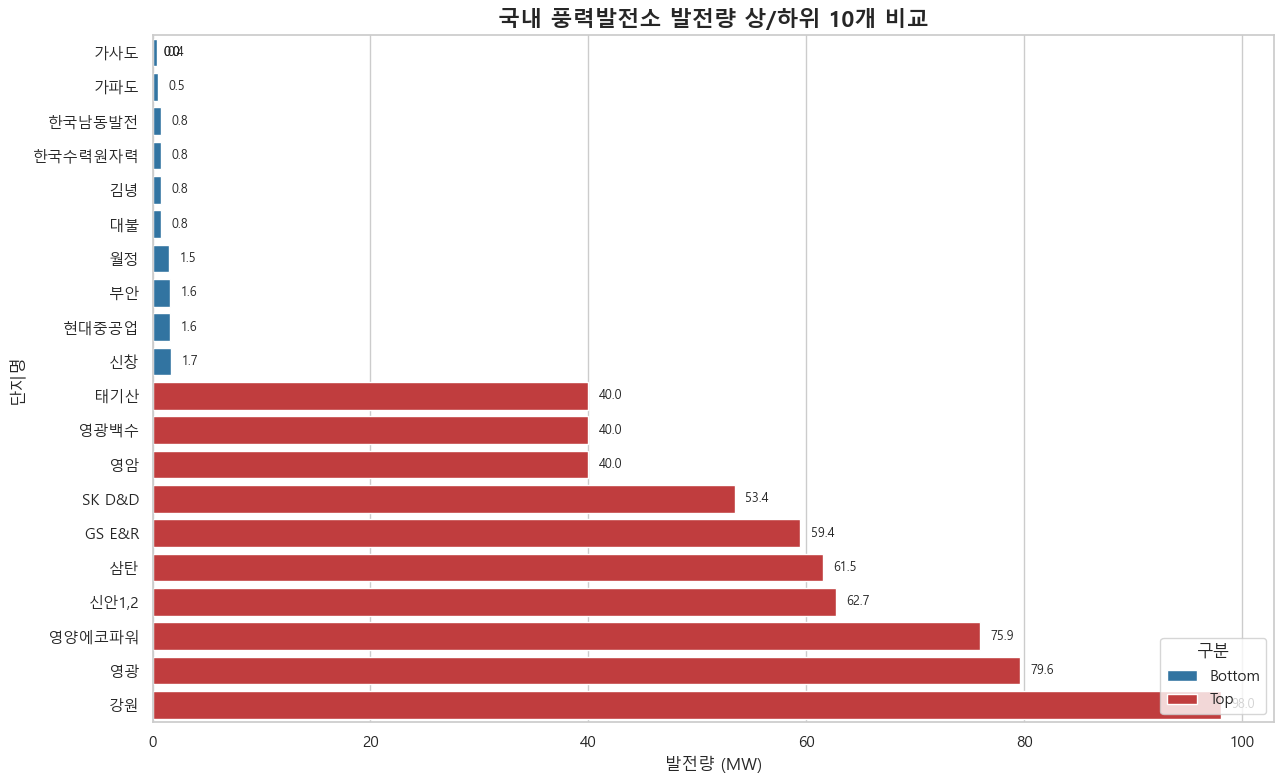

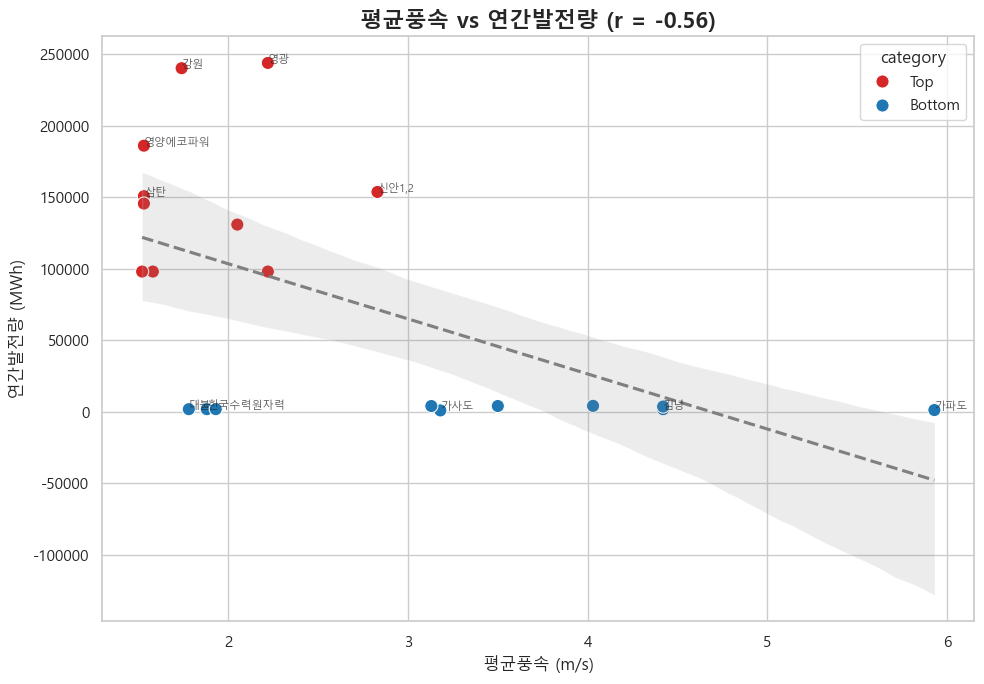

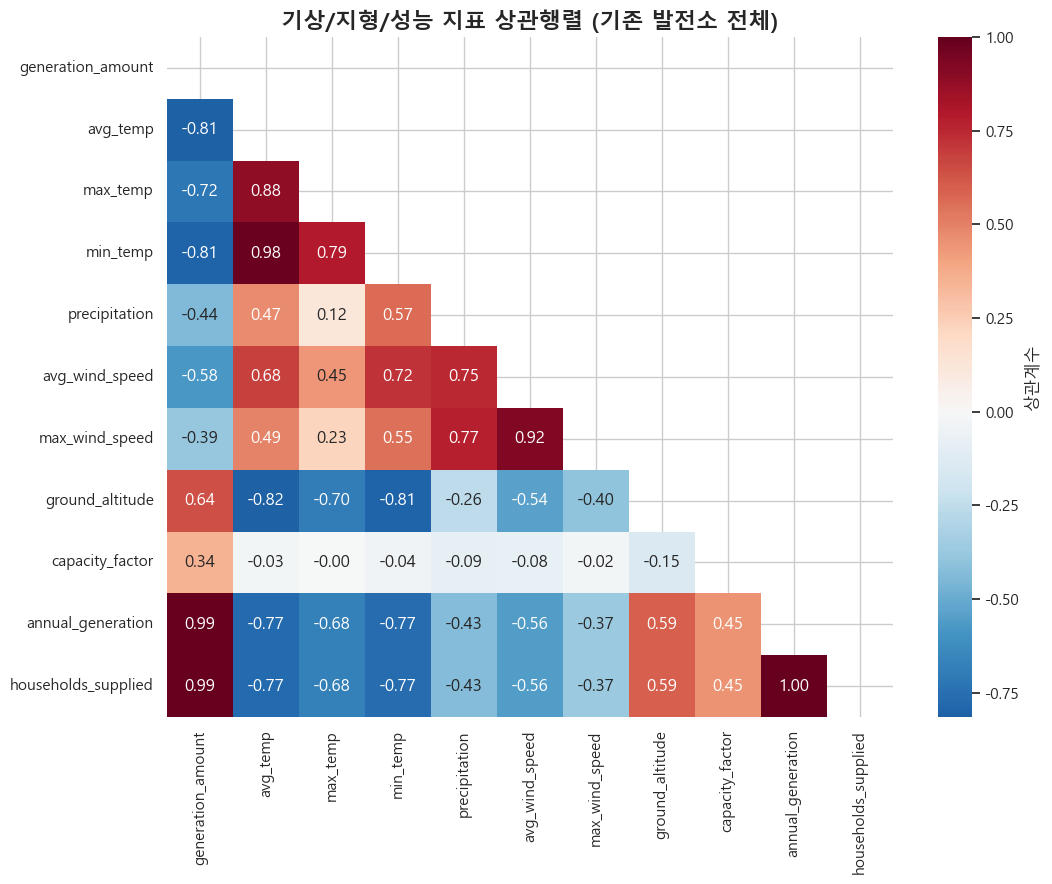

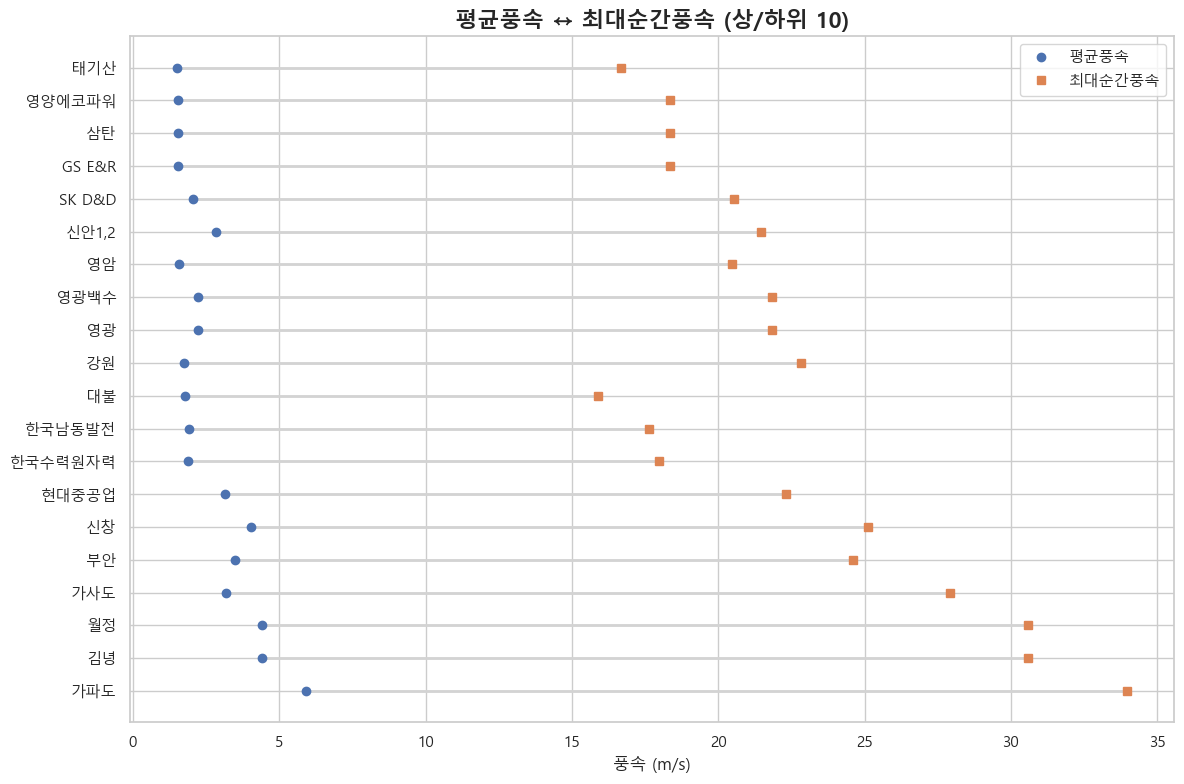

[건너뜀] 레이더: 데이터가 없습니다.
완료 ✅  PNG 파일이 'figures' 폴더에 저장되었습니다.


In [53]:
# -*- coding: utf-8 -*-
"""
국내 풍력발전소 시각화 (Seaborn + Matplotlib, 한글 폰트 적용)
- 입력 파일 1: wind_atlas_original.xlsx (기존 발전소)
- 입력 파일 2: wind_atlas_recommend.xlsx (신규 추천 단지)

그래프 5종(요청 포맷 준수, 저장 + 주석/레이블 보강)
1) 상·하위 10개 발전량 막대그래프 (barh)
2) 평균풍속 vs 연간발전량 산점도 (+회귀선, 상관계수 표시)
3) 기상/지형/성능 상관행렬 히트맵 (숫자형 자동정리)
4) 평균풍속 ↔ 최대순간풍속 덤벨 플롯 (상/하위 10, 변동폭 기준 정렬)
5) 신규 추천 5개 단지 레이더 차트 (정규화, 결측/열부족 자동 처리)

사용법
$ pip install pandas numpy matplotlib seaborn openpyxl
$ python wind_viz.py  # 본 파일명을 wind_viz.py로 저장 후 실행

결과: ./figures 폴더에 PNG로 저장되며, plt.show()로도 즉시 확인 가능
"""

import os
from math import pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# 한글 폰트 설정
# =============================
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows: 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False

FIG_DIR = 'figures'
os.makedirs(FIG_DIR, exist_ok=True)

# =============================
# 유틸: 숫자 정리/정규화/검증
# =============================
def _coerce_numeric(series: pd.Series, percent: bool = False) -> pd.Series:
    s = series.copy()
    if s.dtype == 'O' or str(s.dtype).startswith('string'):
        s = (
            s.astype(str)
            .str.replace('​', '', regex=False)  # zero-width
            .str.replace(',', '', regex=False)
            .str.replace('%', '', regex=False)
            .str.strip()
        )
    s = pd.to_numeric(s, errors='coerce')
    # percent=True라도 축/레이블은 % 단위로 표기하므로 0~100 그대로 둠
    return s


def _clean_numeric_columns(df: pd.DataFrame, cols: list, percent_cols: list | None = None) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            df[c] = _coerce_numeric(df[c], percent=(percent_cols and c in percent_cols))
    return df


def _minmax(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        if c in out.columns:
            x = out[c].astype(float)
            rng = (x.max() - x.min())
            out[c] = (x - x.min()) / (rng if rng != 0 else 1)
    return out


def _require_columns(df: pd.DataFrame, cols: list, context: str) -> bool:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print(f"[건너뜀] {context}: 필요한 컬럼 누락 → {missing}")
        return False
    return True

# =============================
# 1) 데이터 로드 & 전처리
# =============================
def load_excel_data(existing_file_path='wind_atlas_original.xlsx', new_sites_file_path='wind_atlas_recommend.xlsx'):
    # 원본 → 영문 컬럼 매핑
    existing_map = {
        '단지명': 'plant_name',
        '발전량(MW)': 'generation_amount',
        '평균기온(℃)': 'avg_temp',
        '최고기온(℃)': 'max_temp',
        '최저기온(℃)': 'min_temp',
        '강수량(mm)': 'precipitation',
        '평균풍속(m/s)': 'avg_wind_speed',
        '최대순간풍속(m/s)': 'max_wind_speed',
        '지면고도(m)': 'ground_altitude',
        '가동률(%)': 'capacity_factor',
        '연간발전량(MWh)': 'annual_generation',
        '공급가구수(월300kWh)': 'households_supplied',
    }
    new_map = {
        '추천 단지': 'site_name',
        '위도': 'latitude',
        '경도': 'longitude',
        '예상 발전량(MW)': 'expected_generation',
        '이용 가능 부지(㎡)': 'available_area',
        '평균기온(℃)': 'avg_temp',
        '최고기온(℃)': 'max_temp',
        '최저기온(℃)': 'min_temp',
        '강수량(mm)': 'precipitation',
        '평균풍속(m/s)': 'avg_wind_speed',
        '상대습도(%)': 'humidity',
        '지면고도(m)': 'ground_altitude',
    }

    # 읽기
    orig = pd.read_excel(existing_file_path).rename(columns=existing_map)
    reco = pd.read_excel(new_sites_file_path).rename(columns=new_map)

    # 숫자형 정리
    orig_num_cols = [
        'generation_amount', 'avg_temp', 'max_temp', 'min_temp', 'precipitation',
        'avg_wind_speed', 'max_wind_speed', 'ground_altitude', 'capacity_factor',
        'annual_generation', 'households_supplied'
    ]
    _clean_numeric_columns(orig, orig_num_cols, percent_cols=['capacity_factor'])
    orig = orig.dropna(subset=['generation_amount'])

    reco_num_cols = [
        'latitude', 'longitude', 'expected_generation', 'available_area', 'avg_temp',
        'max_temp', 'min_temp', 'precipitation', 'avg_wind_speed', 'humidity', 'ground_altitude'
    ]
    _clean_numeric_columns(reco, reco_num_cols, percent_cols=['humidity'])
    reco = reco.dropna(subset=['expected_generation'])

    # 상/하위 10 선정
    n_top = min(10, len(orig))
    n_bot = min(10, len(orig))
    top10 = orig.nlargest(n_top, 'generation_amount').copy()
    bottom10 = orig.nsmallest(n_bot, 'generation_amount').copy()
    top10['category'] = 'Top'
    bottom10['category'] = 'Bottom'
    combo20 = pd.concat([top10, bottom10], ignore_index=True)

    return orig, combo20, reco

# =============================
# 2) 상·하위 10개 발전량 막대그래프
# =============================
def plot_bar_top_bottom(combo20: pd.DataFrame, save=True, show=True):
    req = ['plant_name', 'generation_amount', 'category']
    if not _require_columns(combo20, req, 'Top/Bottom 막대그래프'):
        return
    plot_df = combo20.sort_values('generation_amount', ascending=True)

    plt.figure(figsize=(13, 8))
    ax = sns.barplot(data=plot_df, y='plant_name', x='generation_amount', hue='category', dodge=False,
                    palette={'Top': '#d62728', 'Bottom': '#1f77b4'})
    ax.set_title('국내 풍력발전소 발전량 상/하위 10개 비교', fontsize=16, weight='bold')
    ax.set_xlabel('발전량 (MW)')
    ax.set_ylabel('단지명')
    # 막대 라벨
    for p in ax.patches:
        w = p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.text(w + max(plot_df['generation_amount']) * 0.01, y, f"{w:,.1f}", va='center', fontsize=9)
    ax.legend(title='구분', loc='lower right')
    plt.tight_layout()

    if show:
        plt.show()
    plt.close()

# =============================
# 3) 평균풍속 vs 연간발전량 산점도 (+회귀, r표시)
# =============================
def plot_scatter_wind_vs_generation(combo20: pd.DataFrame, save=True, show=True):
    req = ['avg_wind_speed', 'annual_generation', 'category']
    if not _require_columns(combo20, req, '풍속 vs 연간발전량 산점도'):
        return

    df = combo20.dropna(subset=['avg_wind_speed', 'annual_generation']).copy()
    r = df['avg_wind_speed'].corr(df['annual_generation'])

    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df, x='avg_wind_speed', y='annual_generation', hue='category', s=90,
                    palette={'Top': '#d62728', 'Bottom': '#1f77b4'})
    sns.regplot(data=df, x='avg_wind_speed', y='annual_generation', scatter=False, color='gray',
                line_kws={'linestyle': '--'})
    # 일부 라벨 (상위 5 + 하위 5만 라벨)
    label_df = pd.concat([
        df.nlargest(5, 'annual_generation'),
        df.nsmallest(5, 'annual_generation')
    ])
    for _, row in label_df.iterrows():
        plt.text(row['avg_wind_speed'], row['annual_generation'], str(row.get('plant_name', '')),
                fontsize=8, alpha=0.75)
    plt.title(f'평균풍속 vs 연간발전량 (r = {r:.2f})', fontsize=16, weight='bold')
    plt.xlabel('평균풍속 (m/s)')
    plt.ylabel('연간발전량 (MWh)')
    plt.tight_layout()

    if show:
        plt.show()
    plt.close()

# =============================
# 4) 상관행렬 히트맵 (숫자만, 자동 처리)
# =============================
def plot_corr_heatmap(orig: pd.DataFrame, save=True, show=True):
    # 관심 지표만 추출(있을 때만)
    candidates = [
        'generation_amount', 'avg_temp', 'max_temp', 'min_temp', 'precipitation',
        'avg_wind_speed', 'max_wind_speed', 'ground_altitude', 'capacity_factor',
        'annual_generation', 'households_supplied'
    ]
    cols = [c for c in candidates if c in orig.columns]
    if not cols:
        print('[건너뜀] 히트맵: 유효한 숫자 컬럼이 없습니다.')
        return

    mat = orig[cols].apply(pd.to_numeric, errors='coerce')
    mat = mat.dropna(how='all', axis=1)  # 전부 NaN인 열 제거
    if mat.shape[1] < 2:
        print('[건너뜀] 히트맵: 상관을 계산할 열이 2개 미만입니다.')
        return

    corr = mat.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(11, 9))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                cbar_kws={'label': '상관계수'})
    plt.title('기상/지형/성능 지표 상관행렬 (기존 발전소 전체)', fontsize=16, weight='bold')
    plt.tight_layout()

    if show:
        plt.show()
    plt.close()

# =============================
# 5) 평균풍속 ↔ 최대순간풍속 덤벨 플롯
# =============================
def plot_dumbbell(combo20: pd.DataFrame, save=True, show=True):
    req = ['plant_name', 'avg_wind_speed', 'max_wind_speed', 'category']
    if not _require_columns(combo20, req, '덤벨 플롯'):
        return

    df = combo20.dropna(subset=['avg_wind_speed', 'max_wind_speed']).copy()
    if df.empty:
        print('[건너뜀] 덤벨: 유효 데이터가 없습니다.')
        return

    df['range'] = (df['max_wind_speed'] - df['avg_wind_speed']).abs()
    df = df.sort_values(['category', 'range', 'plant_name'], ascending=[True, False, True])

    plt.figure(figsize=(12, 8))
    y = np.arange(len(df))
    # 연결선
    plt.hlines(y=y, xmin=df['avg_wind_speed'], xmax=df['max_wind_speed'], color='lightgray', lw=2)
    # 점
    plt.plot(df['avg_wind_speed'], y, 'o', label='평균풍속')
    plt.plot(df['max_wind_speed'], y, 's', label='최대순간풍속')
    plt.yticks(y, df['plant_name'])
    plt.xlabel('풍속 (m/s)')
    plt.title('평균풍속 ↔ 최대순간풍속 (상/하위 10)', fontsize=16, weight='bold')
    plt.legend()
    plt.tight_layout()

    if show:
        plt.show()
    plt.close()

# =============================
# 6) 추천 5개 단지 레이더 차트 (정규화)
# =============================
def plot_radar_recommend(reco: pd.DataFrame, save=True, show=True):
    if 'expected_generation' not in reco.columns:
        print('[건너뜀] 레이더: expected_generation 열이 없습니다.')
        return

    # 추천 5개 자동선정
    reco5 = reco.sort_values('expected_generation', ascending=False).head().copy()
    if reco5.empty:
        print('[건너뜀] 레이더: 데이터가 없습니다.')
        return

    # 사용할 지표 (존재하는 것만)
    metrics_cand = ['expected_generation', 'available_area', 'avg_wind_speed', 'humidity', 'ground_altitude']
    metrics = [c for c in metrics_cand if c in reco5.columns]
    if len(metrics) < 3:
        print('[건너뜀] 레이더: 3개 이상의 지표가 필요합니다. 현재:', metrics)
        return

    # 전체 추천 데이터 기준으로 정규화 → 상호 비교 공정성 확보
    norm_base = reco.copy()
    norm_base = norm_base[metrics].apply(pd.to_numeric, errors='coerce')
    norm_all = _minmax(norm_base, metrics)

    # 레이더에 들어갈 5개만 추출
    idx = reco5.index
    norm5 = norm_all.loc[idx, metrics]

    labels_map = {
        'expected_generation': '예상 발전량(MW)',
        'available_area': '이용 가능 부지(㎡)',
        'avg_wind_speed': '평균풍속(m/s)',
        'humidity': '상대습도(%)',
        'ground_altitude': '지면고도(m)'
    }
    labels = [labels_map.get(m, m) for m in metrics]

    N = len(metrics)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(9, 9))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1.05)

    for i, ridx in enumerate(idx):
        vals = norm5.loc[ridx, :].astype(float).tolist()
        vals += vals[:1]
        name = str(reco.loc[ridx, 'site_name']) if 'site_name' in reco.columns else f'Site {i+1}'
        ax.plot(angles, vals, linewidth=2)
        ax.fill(angles, vals, alpha=0.12)

    ax.set_title('신규 추천 5개 단지 레이더 차트 (정규화)', fontsize=16, weight='bold')
    # 범례
    legend_labels = [str(reco.loc[r, 'site_name']) if 'site_name' in reco.columns else f'Site {k+1}'
                    for k, r in enumerate(idx)]
    ax.legend(legend_labels, loc='upper right', bbox_to_anchor=(1.15, 1.10))

    plt.tight_layout()
    
    if show:
        plt.show()
    plt.close()

# =============================
# 메인 실행부
# =============================
if __name__ == '__main__':
    orig, combo20, reco = load_excel_data('wind_atlas_original.xlsx', 'wind_atlas_recommend.xlsx')

    # 1) Top/Bottom 막대그래프
    plot_bar_top_bottom(combo20, save=True, show=True)

    # 2) 풍속 vs 연간발전량 산점도
    plot_scatter_wind_vs_generation(combo20, save=True, show=True)

    # 3) 상관행렬 히트맵
    plot_corr_heatmap(orig, save=True, show=True)

    # 4) 덤벨 플롯
    plot_dumbbell(combo20, save=True, show=True)

    # 5) 추천 5개 레이더 차트
    plot_radar_recommend(reco, save=True, show=True)

    print(f"완료 ✅  PNG 파일이 '{FIG_DIR}' 폴더에 저장되었습니다.")


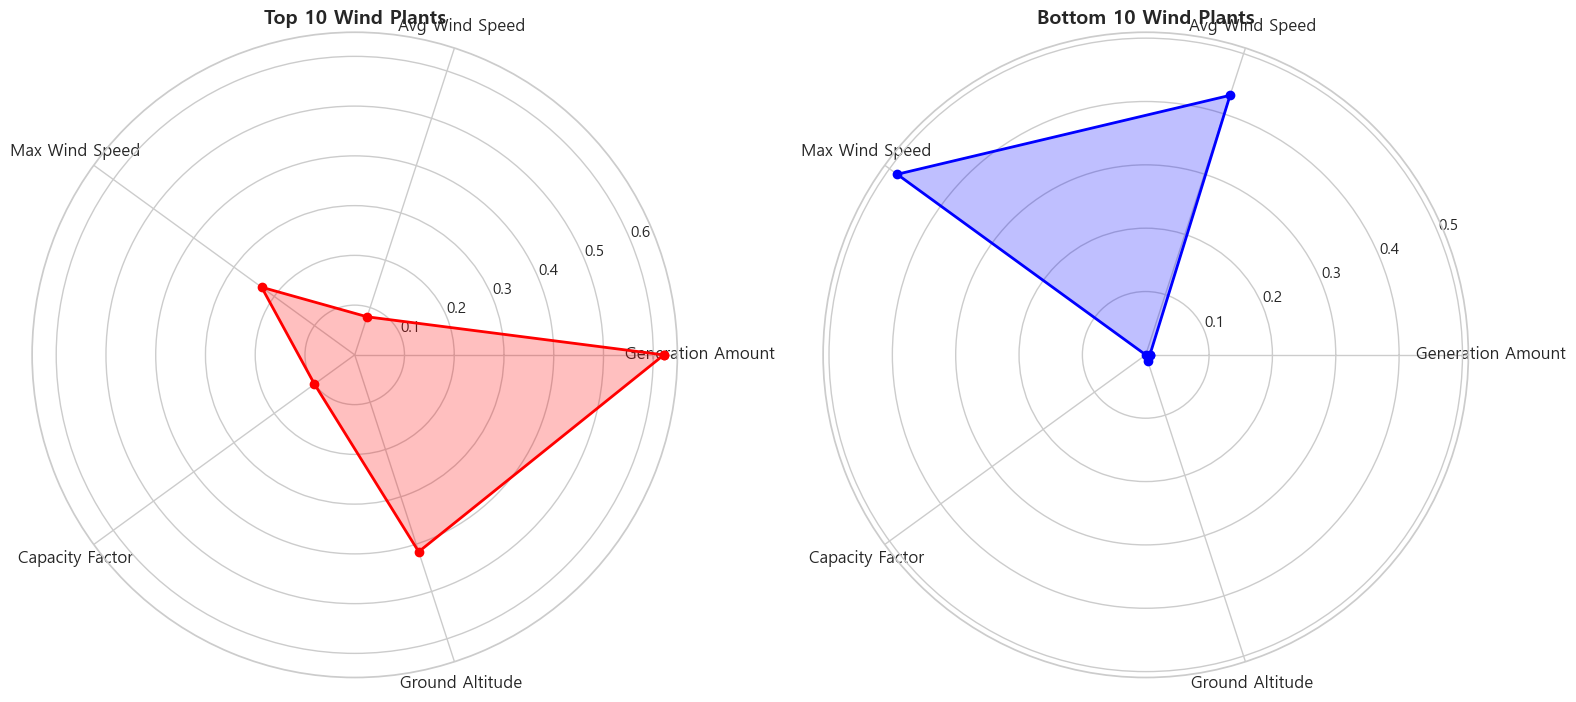

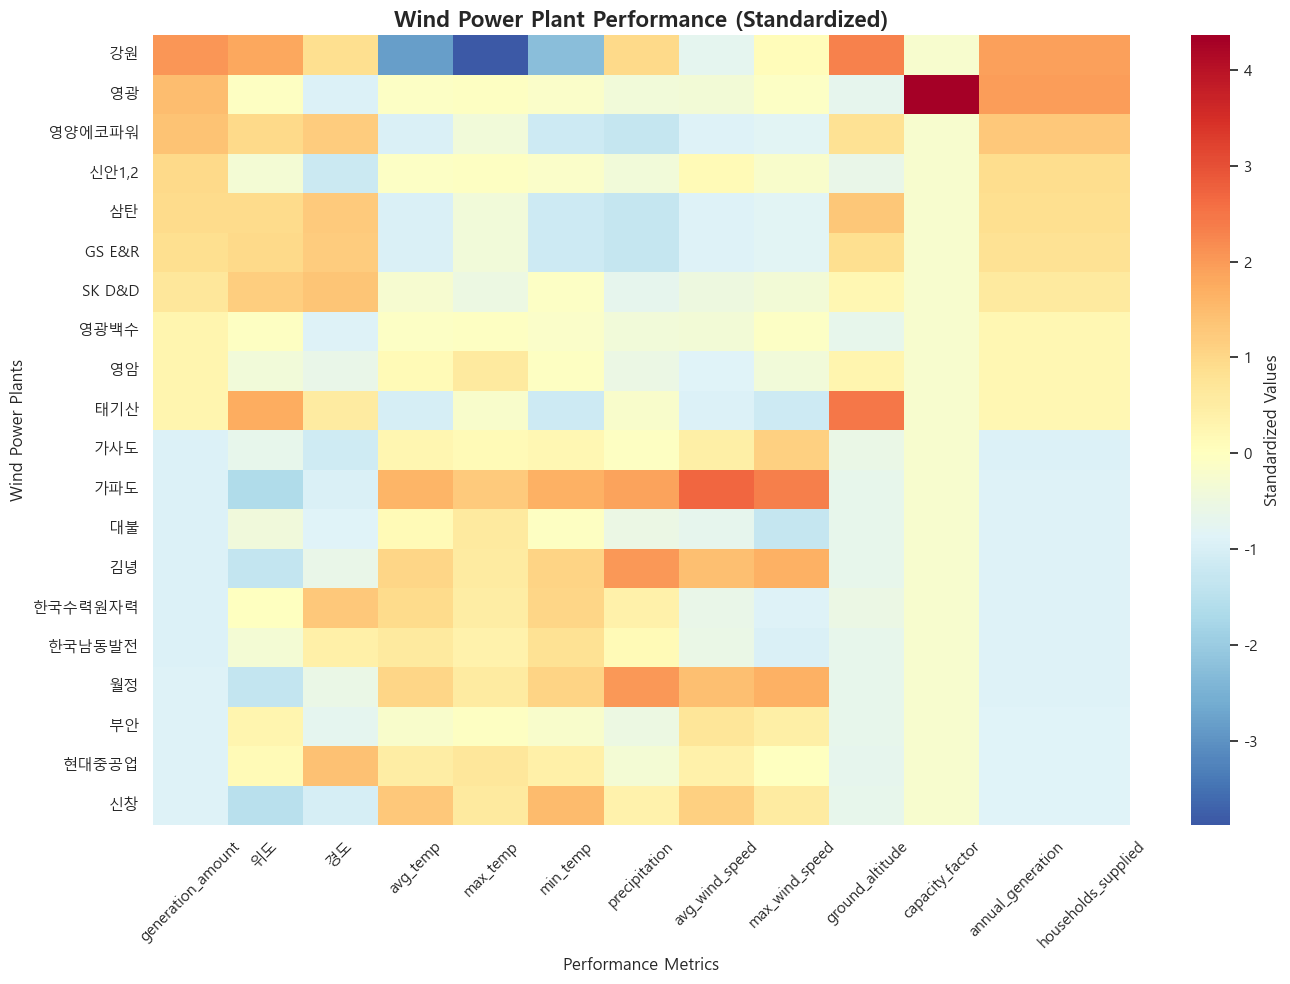

In [97]:
# 1. 엑셀 데이터 불러오고 컬럼명 변경, 상하위 10개 선정
def load_excel_data(existing_file_path='wind_atlas_original.xlsx', new_sites_file_path='wind_atlas_recommend.xlsx'):
    # 기존 발전소 컬럼명 매핑
    existing_column_mapping = {
        '단지명': 'plant_name',
        '발전량(MW)': 'generation_amount',
        '평균기온(℃)': 'avg_temp',
        '최고기온(℃)': 'max_temp',
        '최저기온(℃)': 'min_temp',
        '강수량(mm)': 'precipitation',
        '평균풍속(m/s)': 'avg_wind_speed',
        '최대순간풍속(m/s)': 'max_wind_speed',
        '지면고도(m)': 'ground_altitude',
        '가동률(%)': 'capacity_factor',
        '연간발전량(MWh)': 'annual_generation',
        '공급가구수(월300kWh)': 'households_supplied'
    }
    existing_df = pd.read_excel(existing_file_path).rename(columns=existing_column_mapping)
    numeric_columns = [
        'generation_amount', 'avg_temp', 'max_temp', 'min_temp', 'precipitation',
        'avg_wind_speed', 'max_wind_speed', 'ground_altitude', 'capacity_factor',
        'annual_generation', 'households_supplied'
    ]
    for col in numeric_columns:
        if col in existing_df.columns:
            existing_df[col] = pd.to_numeric(existing_df[col], errors='coerce')
    existing_df = existing_df.dropna()

    # 상위/하위 10개 선정 (발전량 기준)
    median_generation = existing_df['generation_amount'].median()
    existing_df['category'] = existing_df['generation_amount'].apply(lambda x: 'Top' if x >= median_generation else 'Bottom')
    top_10 = existing_df.nlargest(10, 'generation_amount')
    bottom_10 = existing_df.nsmallest(10, 'generation_amount')
    existing_df = pd.concat([top_10, bottom_10], ignore_index=True)
    existing_df['category'] = ['Top'] * 10 + ['Bottom'] * 10

    # 신규 추천 발전소 컬럼명 매핑
    new_column_mapping = {
        '추천 단지': 'site_name',
        '위도': 'latitude', 
        '경도': 'longitude',
        '예상 발전량(MW)': 'expected_generation',
        '이용 가능 부지(㎡)': 'available_area',
        '평균기온(℃)': 'avg_temp',
        '최고기온(℃)': 'max_temp',
        '최저기온(℃)': 'min_temp',
        '강수량(mm)': 'precipitation',
        '평균풍속(m/s)': 'avg_wind_speed',
        '상대습도(%)': 'humidity',
        '지면고도(m)': 'ground_altitude'
    }
    new_df = pd.read_excel(new_sites_file_path).rename(columns=new_column_mapping)

    return existing_df, new_df

###################################################################################################
# 2. 레이더 차트(상위 vs 하위)
def create_radar_chart(df):
    metrics = ['generation_amount', 'avg_wind_speed', 'max_wind_speed', 'capacity_factor', 'ground_altitude']
    metric_labels = ['Generation Amount', 'Avg Wind Speed', 'Max Wind Speed', 'Capacity Factor', 'Ground Altitude']

    top_means = df[df['category'] == 'Top'][metrics].mean()
    bottom_means = df[df['category'] == 'Bottom'][metrics].mean()
    max_vals = df[metrics].max()
    min_vals = df[metrics].min()
    top_norm = (top_means - min_vals) / (max_vals - min_vals)
    bottom_norm = (bottom_means - min_vals) / (max_vals - min_vals)
    angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
    angles += angles[:1]

    plt.figure(figsize=(16,8))
    # Top group
    ax1 = plt.subplot(1,2,1, polar=True)
    values_top = top_norm.values.tolist()
    values_top += values_top[:1]
    ax1.plot(angles, values_top, 'o-', linewidth=2, label='Top 10', color='red')
    ax1.fill(angles, values_top, alpha=0.25, color='red')
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(metric_labels, fontsize=12)
    ax1.set_title('Top 10 Wind Plants', size=14, weight='bold')
    ax1.grid(True)
    # Bottom group
    ax2 = plt.subplot(1,2,2, polar=True)
    values_bot = bottom_norm.values.tolist()
    values_bot += values_bot[:1]
    ax2.plot(angles, values_bot, 'o-', linewidth=2, label='Bottom 10', color='blue')
    ax2.fill(angles, values_bot, alpha=0.25, color='blue')
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(metric_labels, fontsize=12)
    ax2.set_title('Bottom 10 Wind Plants', size=14, weight='bold')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

###################################################################################################
# 3. 히트맵
def create_heatmap(df):
    plt.figure(figsize=(14, 10))
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'category']
    heatmap_data = df[numeric_cols]
    heatmap_index = df['plant_name'] if 'plant_name' in df.columns else df.index
    normalized = (heatmap_data - heatmap_data.mean()) / heatmap_data.std(ddof=0)
    normalized.index = heatmap_index

    sns.heatmap(normalized, 
                annot=False, 
                cmap='RdYlBu_r', 
                center=0,
                cbar_kws={'label': 'Standardized Values'})
    plt.title('Wind Power Plant Performance (Standardized)', size=16, weight='bold')
    plt.xlabel('Performance Metrics')
    plt.ylabel('Wind Power Plants')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


###################################################################################################
existing_plants, new_sites = load_excel_data('wind_atlas_original.xlsx', 'wind_atlas_recommend.xlsx')

# 기존 발전소 데이터로 시각화
create_radar_chart(existing_plants)
create_heatmap(existing_plants)



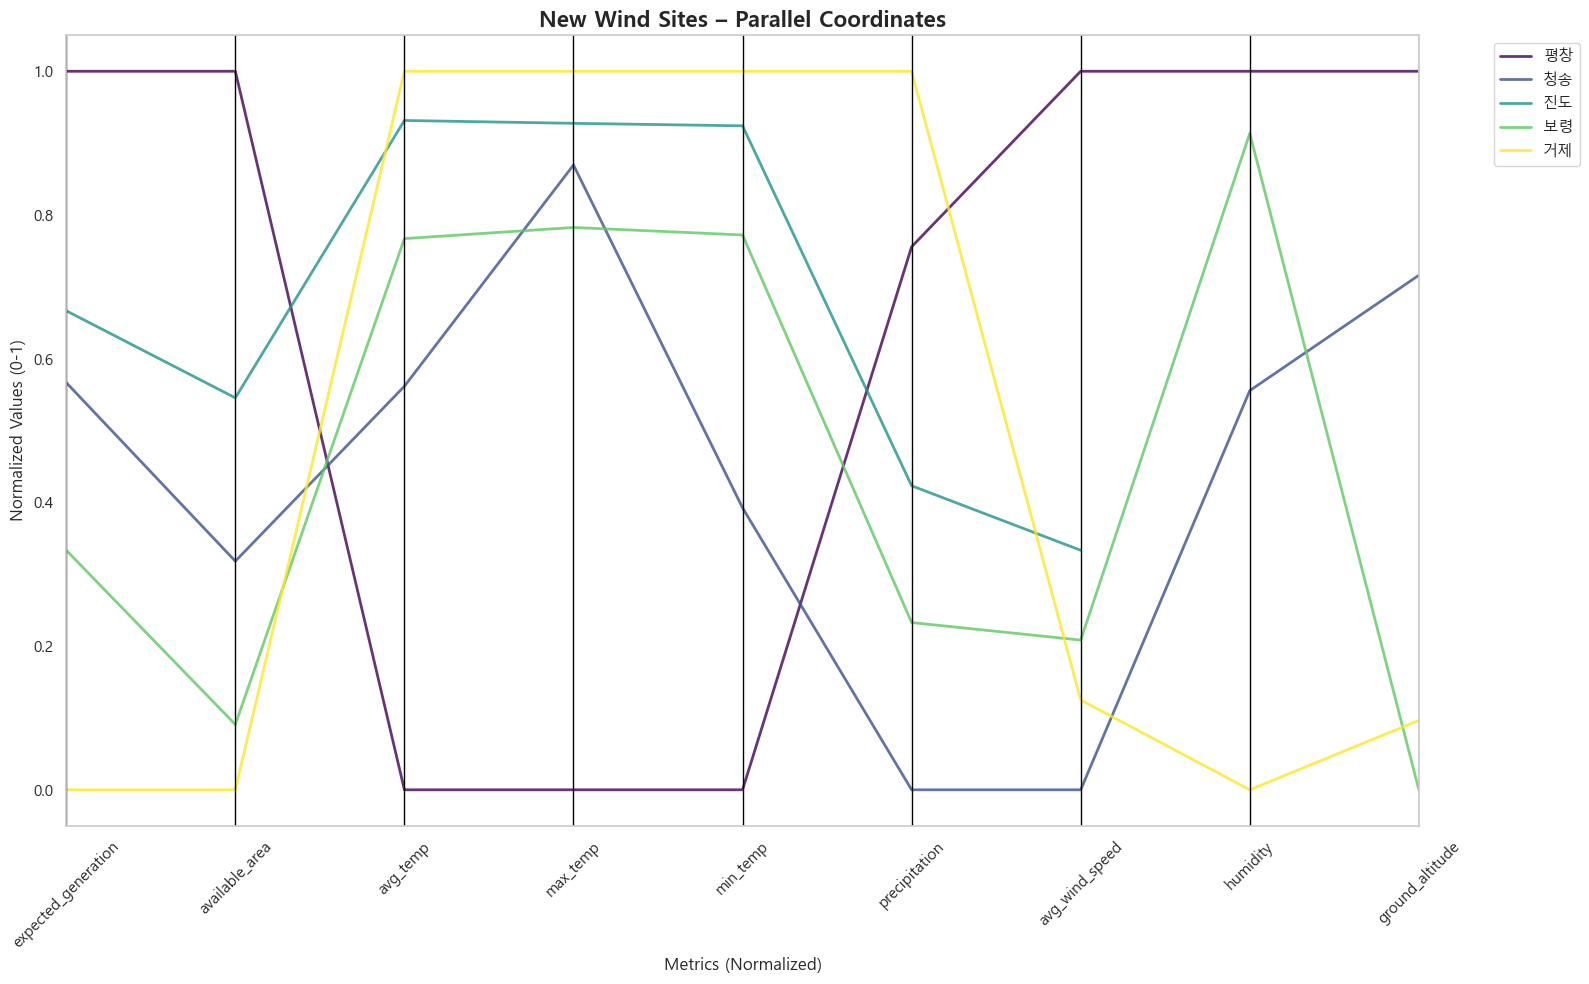

In [98]:
# 5. F. 평행 좌표 플롯 - 신규 추천지 비교
def create_parallel_coordinates(new_df):
    plt.figure(figsize=(16, 10))
    # 숫자형 컬럼만 정규화
    numeric_cols = new_df.select_dtypes(include=[float, int]).columns
    normalized_df = new_df.copy()
    for col in numeric_cols:
        min_val = new_df[col].min()
        max_val = new_df[col].max()
        normalized_df[col] = (new_df[col] - min_val) / (max_val - min_val)
    normalized_df['site_name'] = new_df['site_name']  # 맵핑
    parallel_coordinates(
        normalized_df, 
        'site_name', 
        cols=numeric_cols.tolist(), 
        color=plt.cm.viridis(np.linspace(0,1,len(new_df))),
        alpha=0.8,
        linewidth=2
    )
    plt.title('New Wind Sites – Parallel Coordinates', fontsize=16, weight='bold')
    plt.xlabel('Metrics (Normalized)')
    plt.ylabel('Normalized Values (0-1)')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

create_parallel_coordinates(new_sites)

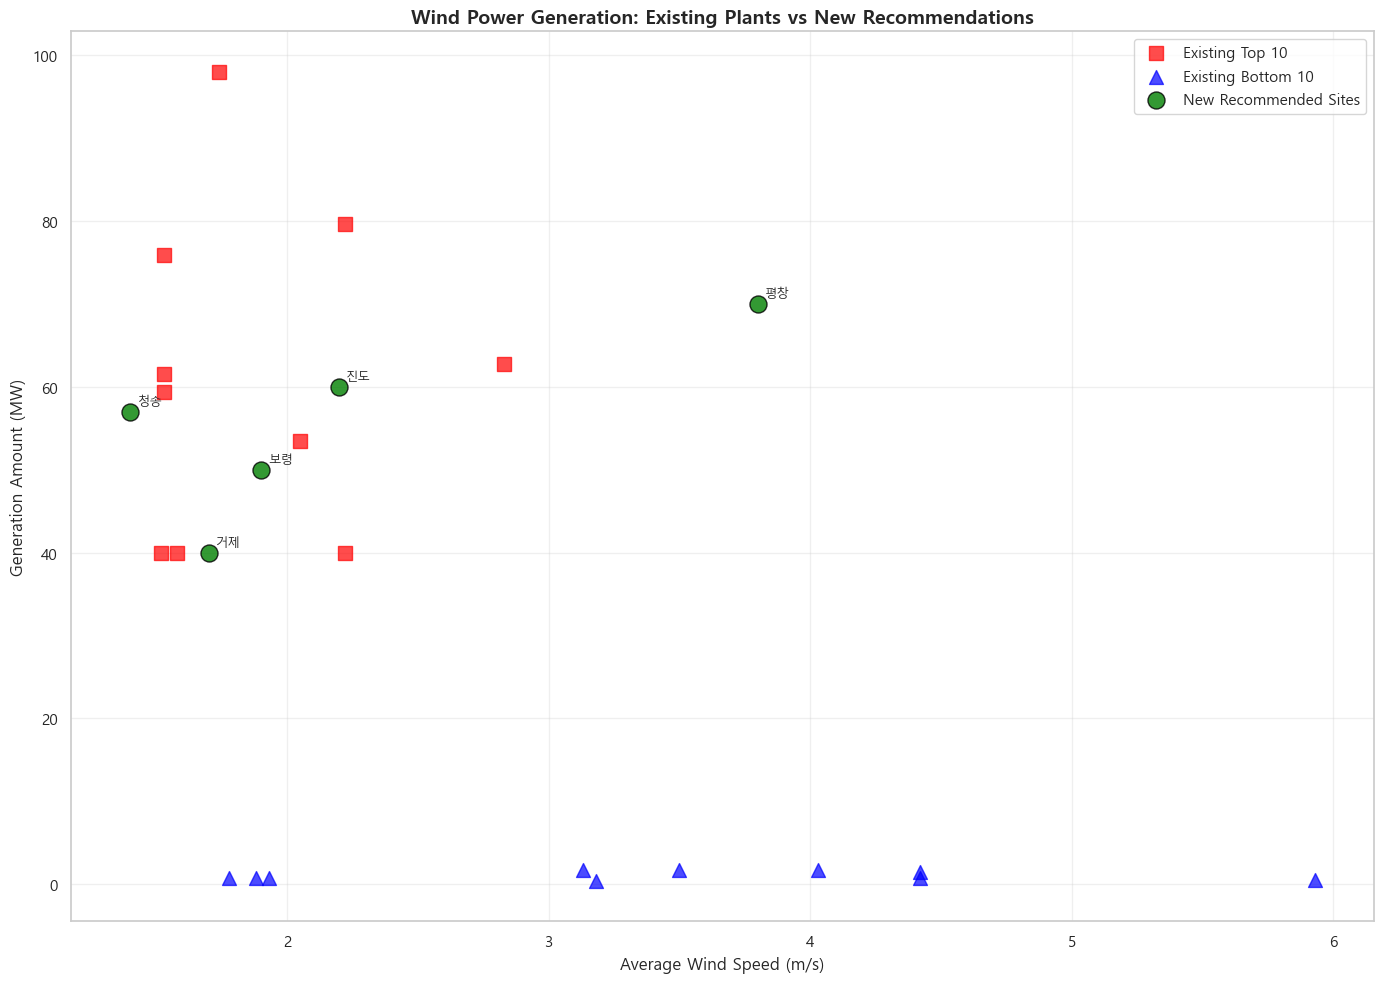

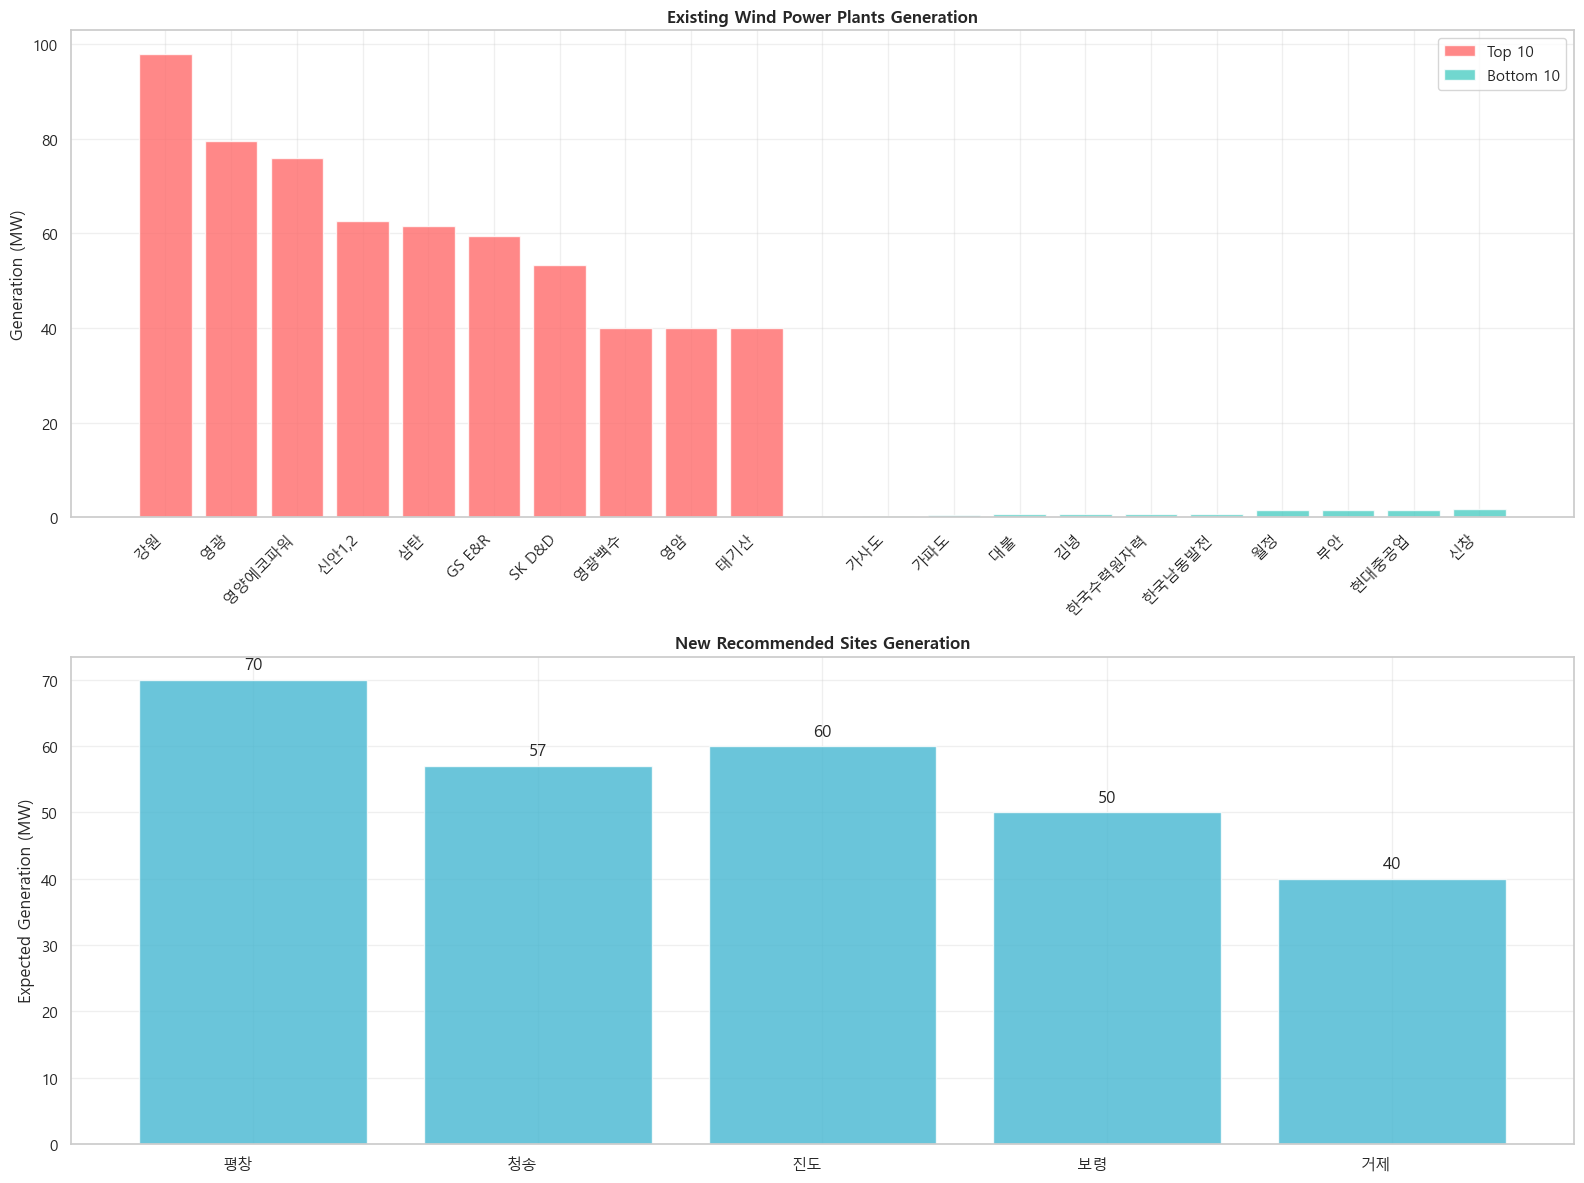

<Figure size 1500x1000 with 0 Axes>

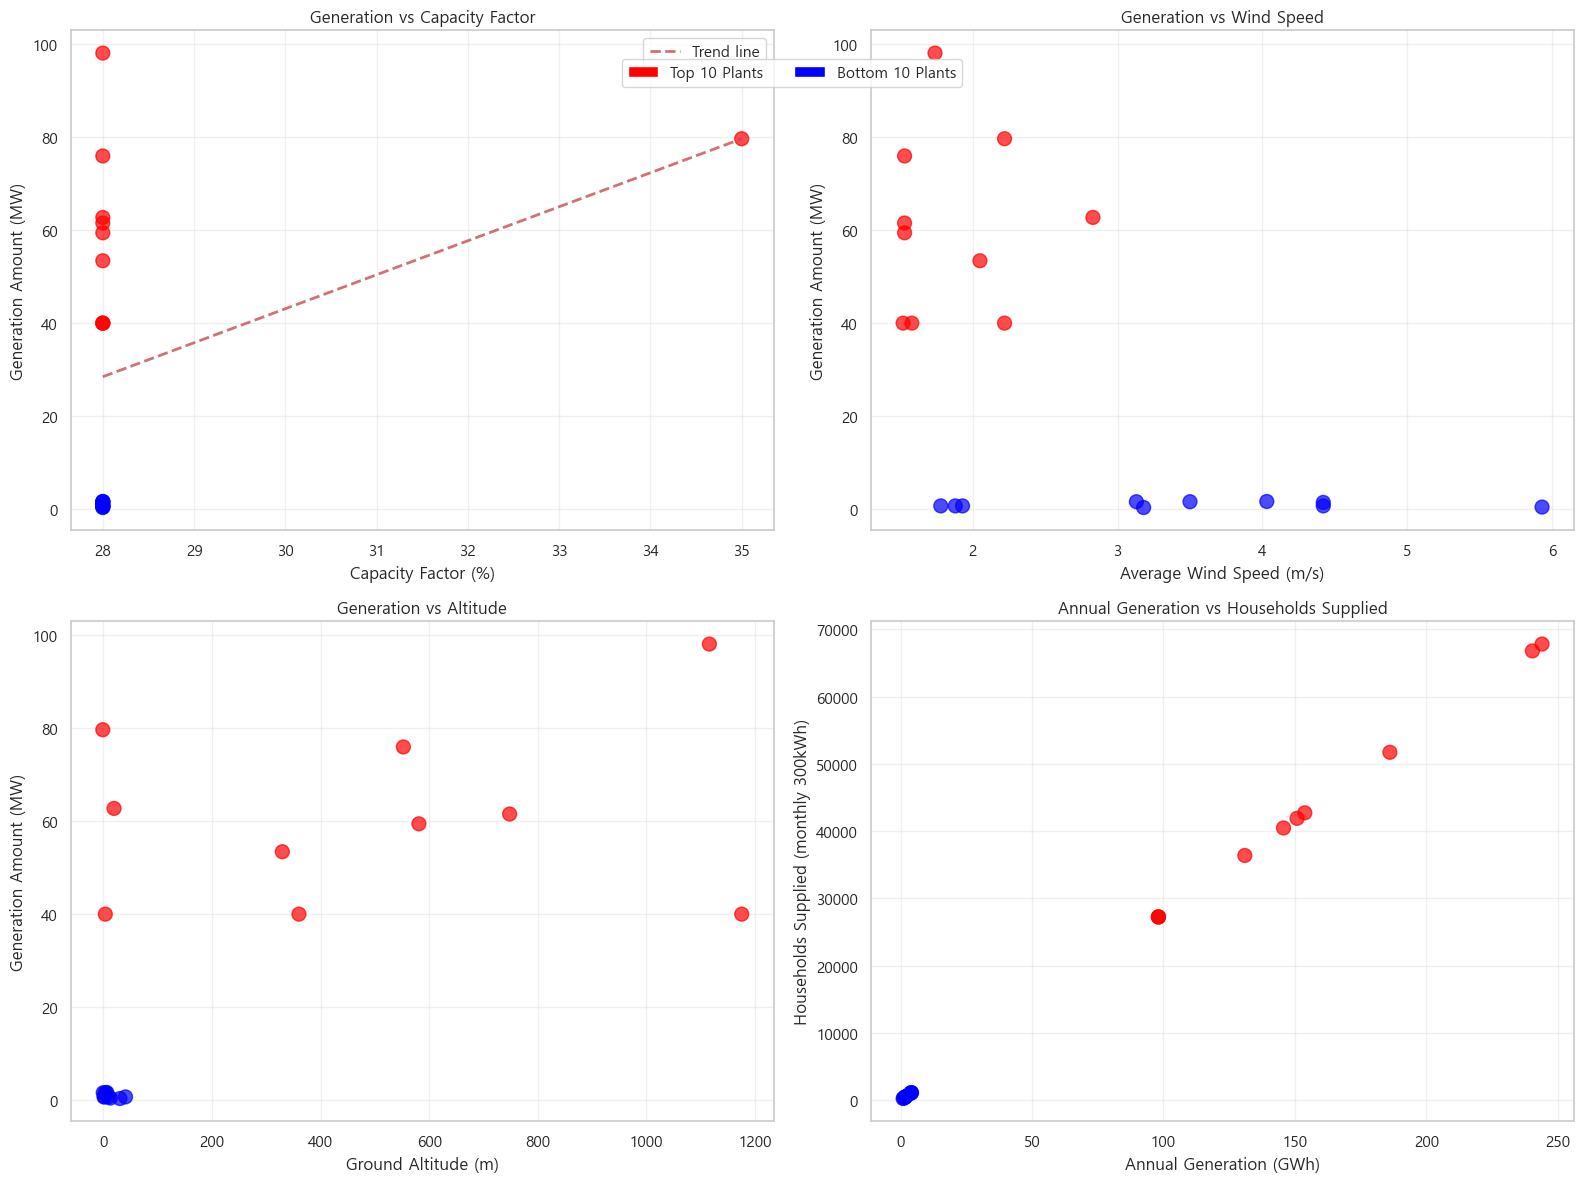

<Figure size 1800x1200 with 0 Axes>

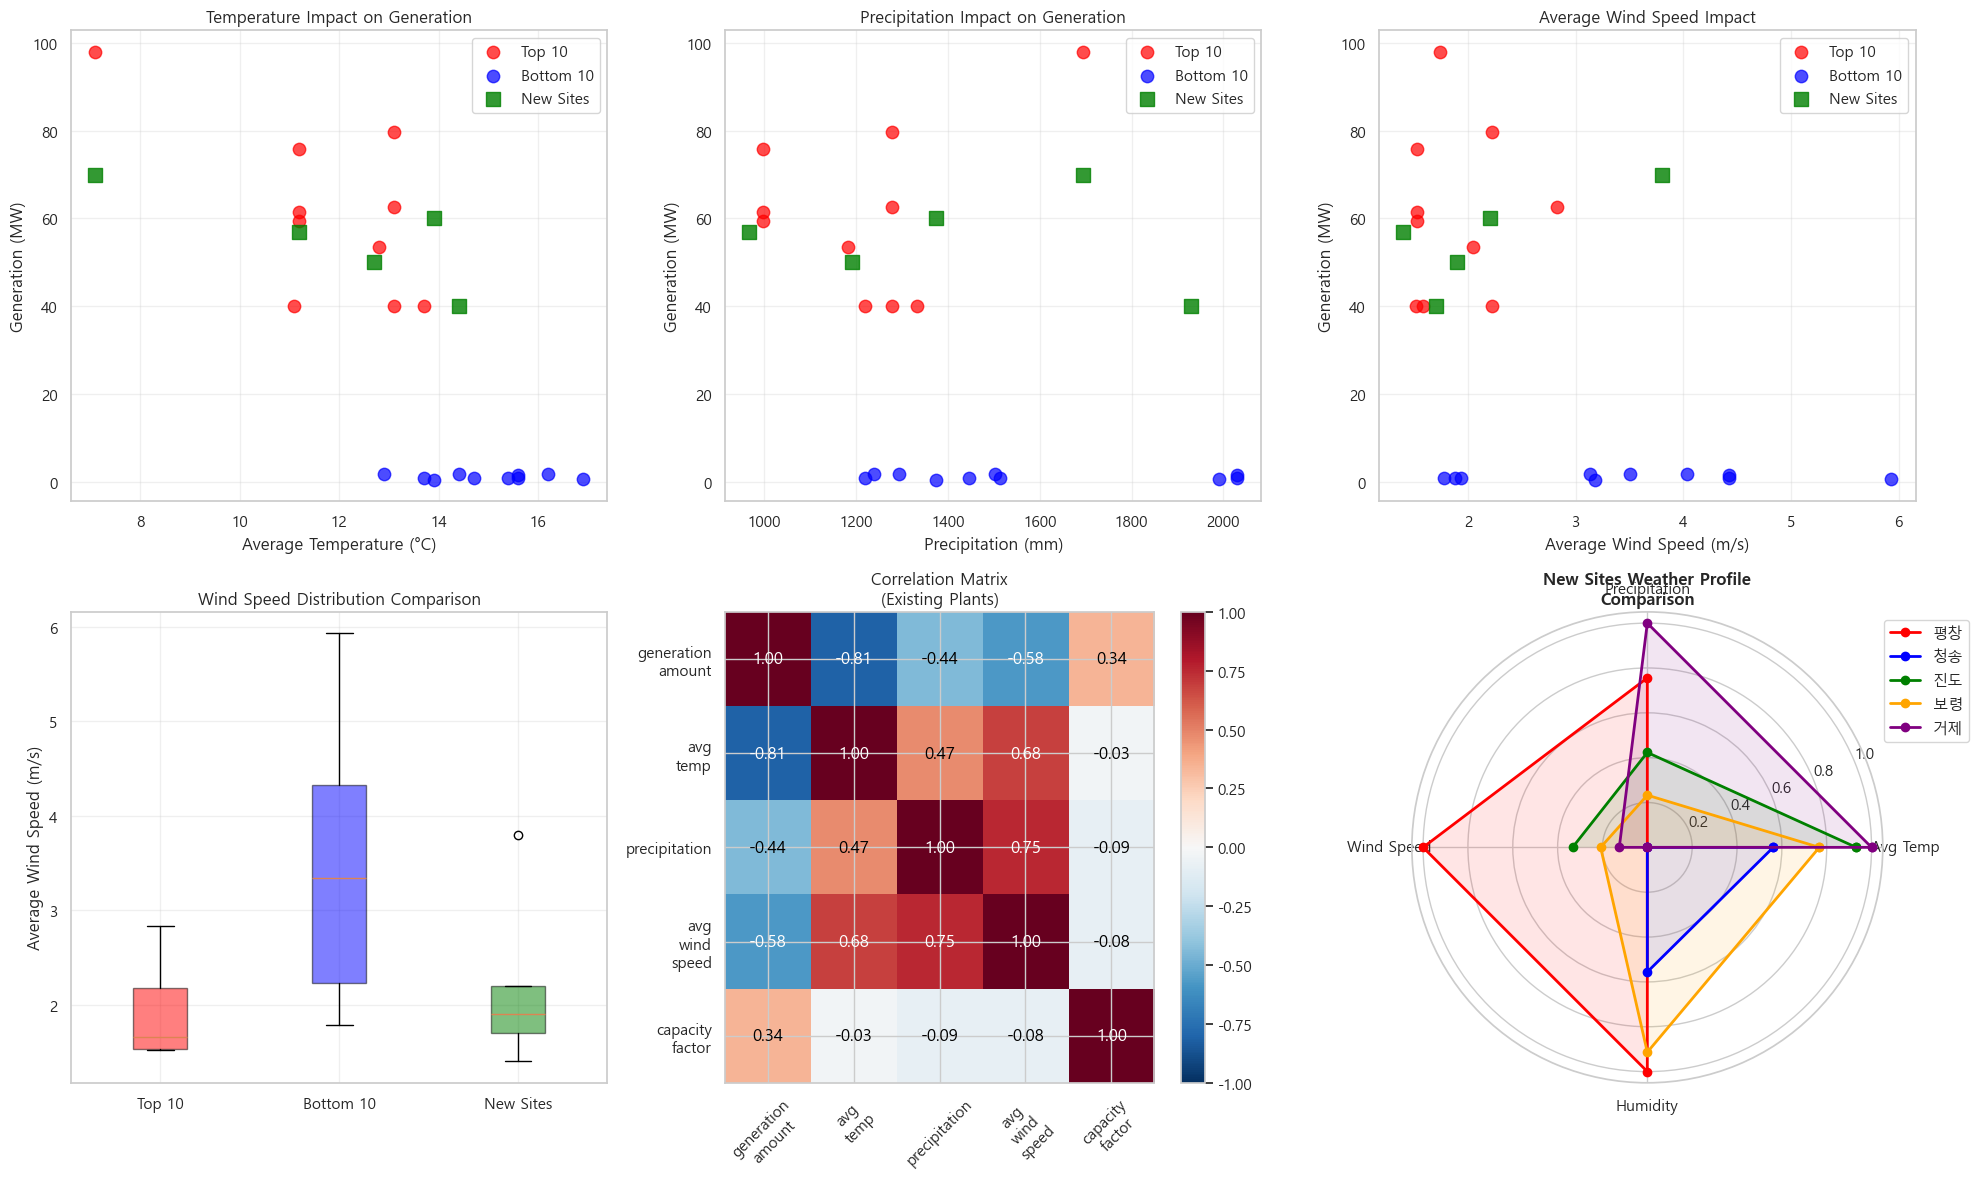

In [115]:


# 8. I. 벤치마킹 차트 - 기존 vs 신규 비교
def create_benchmarking_chart(existing_df, new_df):
        plt.figure(figsize=(14, 10))
        
        # 기존 상위 발전소
        top_plants = existing_df[existing_df['category'] == 'Top']
        plt.scatter(top_plants['avg_wind_speed'], top_plants['generation_amount'], 
                s=100, c='red', marker='s', label='Existing Top 10', alpha=0.7)
        
        # 기존 하위 발전소
        bottom_plants = existing_df[existing_df['category'] == 'Bottom']
        plt.scatter(bottom_plants['avg_wind_speed'], bottom_plants['generation_amount'], 
                s=100, c='blue', marker='^', label='Existing Bottom 10', alpha=0.7)
        
        # 신규 추천지
        plt.scatter(new_df['avg_wind_speed'], new_df['expected_generation'], 
                s=150, c='green', marker='o', label='New Recommended Sites', alpha=0.8, edgecolor='black')
        
        # 신규 사이트에 라벨 추가
        for i, site in enumerate(new_df['site_name']):
                plt.annotate(site, (new_df['avg_wind_speed'].iloc[i], new_df['expected_generation'].iloc[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        plt.xlabel('Average Wind Speed (m/s)', size=12)
        plt.ylabel('Generation Amount (MW)', size=12)
        plt.title('Wind Power Generation: Existing Plants vs New Recommendations', size=14, weight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# 9. J. 바 차트 - 발전량 기여도와 지역 분포
def create_treemap(existing_df, new_df):
        # squarify가 없으면 대체 바 차트
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
                
        # 기존 발전소 바 차트
        top_plants = existing_df[existing_df['category'] == 'Top']
        bottom_plants = existing_df[existing_df['category'] == 'Bottom']
                
        x_pos_top = np.arange(len(top_plants))
        x_pos_bottom = np.arange(len(bottom_plants))
                
        ax1.bar(x_pos_top, top_plants['generation_amount'], 
                color='#FF6B6B', alpha=0.8, label='Top 10')
        ax1.bar(x_pos_bottom + len(top_plants) + 1, bottom_plants['generation_amount'], 
                color='#4ECDC4', alpha=0.8, label='Bottom 10')
                
        all_existing = list(top_plants['plant_name']) + [''] + list(bottom_plants['plant_name'])
        ax1.set_xticks(range(len(all_existing)))
        ax1.set_xticklabels(all_existing, rotation=45, ha='right')
        ax1.set_ylabel('Generation (MW)')
        ax1.set_title('Existing Wind Power Plants Generation', weight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
                
        # 신규 추천지 바 차트
        x_pos_new = np.arange(len(new_df))
        bars = ax2.bar(x_pos_new, new_df['expected_generation'], 
                        color='#45B7D1', alpha=0.8)
        ax2.set_xticks(x_pos_new)
        ax2.set_xticklabels(new_df['site_name'],  ha='right')
        ax2.set_ylabel('Expected Generation (MW)')
        ax2.set_title('New Recommended Sites Generation', weight='bold')
        ax2.grid(True, alpha=0.3)
                
        # 값 표시
        for bar in bars:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{height:.0f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

# 10. 추가 분석 함수들

def create_location_map(new_df):
        """신규 추천지 위치를 지도에 표시"""
        if 'latitude' in new_df.columns and 'longitude' in new_df.columns:
                plt.figure(figsize=(12, 8))
                
                # 한국 지도 범위 설정
                plt.xlim(125, 132)
                plt.ylim(33, 39)
                
                # 산점도로 위치 표시
                scatter = plt.scatter(new_df['longitude'], new_df['latitude'], 
                                c=new_df['expected_generation'], 
                                s=new_df['available_area']/50000,  # 부지 크기에 비례한 점 크기
                                cmap='viridis', 
                                alpha=0.8,
                                edgecolors='black')
                
                # 각 지점에 라벨 추가
                for i, site in enumerate(new_df['site_name']):
                        plt.annotate(f"{site}\n{new_df['expected_generation'].iloc[i]:.0f}MW", 
                                (new_df['longitude'].iloc[i], new_df['latitude'].iloc[i]),
                                xytext=(5, 5), textcoords='offset points', 
                                fontsize=9, ha='left')
                
                        plt.colorbar(scatter, label='Expected Generation (MW)')
                        plt.xlabel('Longitude (°)')
                        plt.ylabel('Latitude (°)')
                        plt.title('New Wind Power Sites Location Map\n(Bubble size = Available Area)', 
                                size=14, weight='bold')
                        plt.grid(True, alpha=0.3)
                        plt.tight_layout()
                        plt.show()
        else:
                print("위도/경도 데이터가 없어 지도 시각화를 건너뜁니다.")

def create_efficiency_analysis(existing_df):
        """발전 효율성 분석 (발전량 대비 부지 면적당 효율)"""
        plt.figure(figsize=(15, 10))
        
        # 2x2 서브플롯
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. 발전량 vs 가동률
        ax1 = axes[0, 0]
        colors = existing_df['category'].map({'Top': 'red', 'Bottom': 'blue'})
        scatter1 = ax1.scatter(existing_df['capacity_factor'], existing_df['generation_amount'], 
                                c=colors, alpha=0.7, s=100)
        ax1.set_xlabel('Capacity Factor (%)')
        ax1.set_ylabel('Generation Amount (MW)')
        ax1.set_title('Generation vs Capacity Factor')
        ax1.grid(True, alpha=0.3)
        
        # 추세선 추가
        z = np.polyfit(existing_df['capacity_factor'], existing_df['generation_amount'], 1)
        p = np.poly1d(z)
        ax1.plot(existing_df['capacity_factor'].sort_values(), 
                p(existing_df['capacity_factor'].sort_values()), 
                "r--", alpha=0.8, linewidth=2, label=f'Trend line')
        ax1.legend()
        
        # 2. 풍속 vs 발전량
        ax2 = axes[0, 1]
        scatter2 = ax2.scatter(existing_df['avg_wind_speed'], existing_df['generation_amount'], 
                                c=colors, alpha=0.7, s=100)
        ax2.set_xlabel('Average Wind Speed (m/s)')
        ax2.set_ylabel('Generation Amount (MW)')
        ax2.set_title('Generation vs Wind Speed')
        ax2.grid(True, alpha=0.3)
        
        # 3. 고도 vs 발전량
        ax3 = axes[1, 0]
        scatter3 = ax3.scatter(existing_df['ground_altitude'], existing_df['generation_amount'], 
                                c=colors, alpha=0.7, s=100)
        ax3.set_xlabel('Ground Altitude (m)')
        ax3.set_ylabel('Generation Amount (MW)')
        ax3.set_title('Generation vs Altitude')
        ax3.grid(True, alpha=0.3)
        
        # 4. 연간발전량 vs 공급가구수
        ax4 = axes[1, 1]
        # MWh를 GWh로 변환하여 표시
        annual_gen_gwh = existing_df['annual_generation'] / 1000
        scatter4 = ax4.scatter(annual_gen_gwh, existing_df['households_supplied'], 
                                c=colors, alpha=0.7, s=100)
        ax4.set_xlabel('Annual Generation (GWh)')
        ax4.set_ylabel('Households Supplied (monthly 300kWh)')
        ax4.set_title('Annual Generation vs Households Supplied')
        ax4.grid(True, alpha=0.3)
        
        # 범례 추가
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='red', label='Top 10 Plants'),
                        Patch(facecolor='blue', label='Bottom 10 Plants')]
        fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)
        
        plt.tight_layout()
        plt.show()

def create_weather_impact_analysis(existing_df, new_df):
        """기상 조건이 발전량에 미치는 영향 분석"""
        plt.figure(figsize=(18, 12))
        
        # 3x2 서브플롯
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        
        # 기존 발전소 데이터
        top_plants = existing_df[existing_df['category'] == 'Top']
        bottom_plants = existing_df[existing_df['category'] == 'Bottom']
        
        # 1. 기온 vs 발전량
        ax1 = axes[0, 0]
        ax1.scatter(top_plants['avg_temp'], top_plants['generation_amount'], 
                c='red', alpha=0.7, s=80, label='Top 10')
        ax1.scatter(bottom_plants['avg_temp'], bottom_plants['generation_amount'], 
                c='blue', alpha=0.7, s=80, label='Bottom 10')
        ax1.scatter(new_df['avg_temp'], new_df['expected_generation'], 
                c='green', alpha=0.8, s=100, marker='s', label='New Sites')
        ax1.set_xlabel('Average Temperature (°C)')
        ax1.set_ylabel('Generation (MW)')
        ax1.set_title('Temperature Impact on Generation')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. 강수량 vs 발전량
        ax2 = axes[0, 1]
        ax2.scatter(top_plants['precipitation'], top_plants['generation_amount'], 
                c='red', alpha=0.7, s=80, label='Top 10')
        ax2.scatter(bottom_plants['precipitation'], bottom_plants['generation_amount'], 
                c='blue', alpha=0.7, s=80, label='Bottom 10')
        ax2.scatter(new_df['precipitation'], new_df['expected_generation'], 
                c='green', alpha=0.8, s=100, marker='s', label='New Sites')
        ax2.set_xlabel('Precipitation (mm)')
        ax2.set_ylabel('Generation (MW)')
        ax2.set_title('Precipitation Impact on Generation')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. 평균풍속 vs 발전량 
        ax3 = axes[0, 2]
        ax3.scatter(top_plants['avg_wind_speed'], top_plants['generation_amount'], 
                c='red', alpha=0.7, s=80, label='Top 10')
        ax3.scatter(bottom_plants['avg_wind_speed'], bottom_plants['generation_amount'], 
                c='blue', alpha=0.7, s=80, label='Bottom 10')
        ax3.scatter(new_df['avg_wind_speed'], new_df['expected_generation'], 
                c='green', alpha=0.8, s=100, marker='s', label='New Sites')
        ax3.set_xlabel('Average Wind Speed (m/s)')
        ax3.set_ylabel('Generation (MW)')
        ax3.set_title('Average Wind Speed Impact')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. 기상조건 박스플롯 비교
        ax4 = axes[1, 0]
        weather_data = [top_plants['avg_wind_speed'], bottom_plants['avg_wind_speed'], new_df['avg_wind_speed']]
        bp = ax4.boxplot(weather_data, labels=['Top 10', 'Bottom 10', 'New Sites'], 
                        patch_artist=True)
        colors = ['red', 'blue', 'green']
        for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.5)
        ax4.set_ylabel('Average Wind Speed (m/s)')
        ax4.set_title('Wind Speed Distribution Comparison')
        ax4.grid(True, alpha=0.3)
        
        # 5. 상관관계 히트맵
        ax5 = axes[1, 1]
        # 기존 발전소의 주요 지표 상관관계
        corr_metrics = ['generation_amount', 'avg_temp', 'precipitation', 'avg_wind_speed', 'capacity_factor']
        corr_matrix = existing_df[corr_metrics].corr()
        im = ax5.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        ax5.set_xticks(range(len(corr_metrics)))
        ax5.set_yticks(range(len(corr_metrics)))
        ax5.set_xticklabels([metric.replace('_', '\n') for metric in corr_metrics], rotation=45)
        ax5.set_yticklabels([metric.replace('_', '\n') for metric in corr_metrics])
        ax5.set_title('Correlation Matrix\n(Existing Plants)')
        
        # 상관계수 값 표시
        for i in range(len(corr_metrics)):
                for j in range(len(corr_metrics)):
                        ax5.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                                ha='center', va='center', 
                                color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')
        
        plt.colorbar(im, ax=ax5)
        
        # 6. 신규 사이트 레이더 차트 (모든 사이트 겹쳐서)
        ax6 = axes[1, 2]
        ax6.remove()
        ax6 = fig.add_subplot(2, 3, 6, projection='polar')
        
        # 신규 사이트들의 기상조건 비교
        weather_metrics = ['avg_temp', 'precipitation', 'avg_wind_speed', 'humidity']
        weather_labels = ['Avg Temp', 'Precipitation', 'Wind Speed', 'Humidity']
        
        angles = [n / float(len(weather_metrics)) * 2 * pi for n in range(len(weather_metrics))]
        angles += angles[:1]
        
        colors_radar = ['red', 'blue', 'green', 'orange', 'purple']
        
        # 정규화
        weather_max = new_df[weather_metrics].max()
        weather_min = new_df[weather_metrics].min()
        
        for i, site in enumerate(new_df['site_name']):
                weather_data = new_df[weather_metrics].iloc[i]
                weather_norm = (weather_data - weather_min) / (weather_max - weather_min)
                values = weather_norm.values.tolist()
                values += values[:1]
                
                ax6.plot(angles, values, 'o-', linewidth=2, 
                        label=site, color=colors_radar[i % len(colors_radar)])
                ax6.fill(angles, values, alpha=0.1, color=colors_radar[i % len(colors_radar)])
        
        ax6.set_xticks(angles[:-1])
        ax6.set_xticklabels(weather_labels)
        ax6.set_title('New Sites Weather Profile\nComparison', weight='bold')
        ax6.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
        
        plt.tight_layout()
        plt.show()

numeric_cols = ['expected_generation', 'available_area', 'avg_temp', 'max_temp', 'min_temp',
                'precipitation', 'avg_wind_speed', 'humidity', 'ground_altitude']



# create_3d_scatter(new_sites)
create_benchmarking_chart(existing_plants, new_sites)
create_treemap(existing_plants, new_sites)
# create_location_map(new_sites)
create_efficiency_analysis(existing_plants)
create_weather_impact_analysis(existing_plants, new_sites)

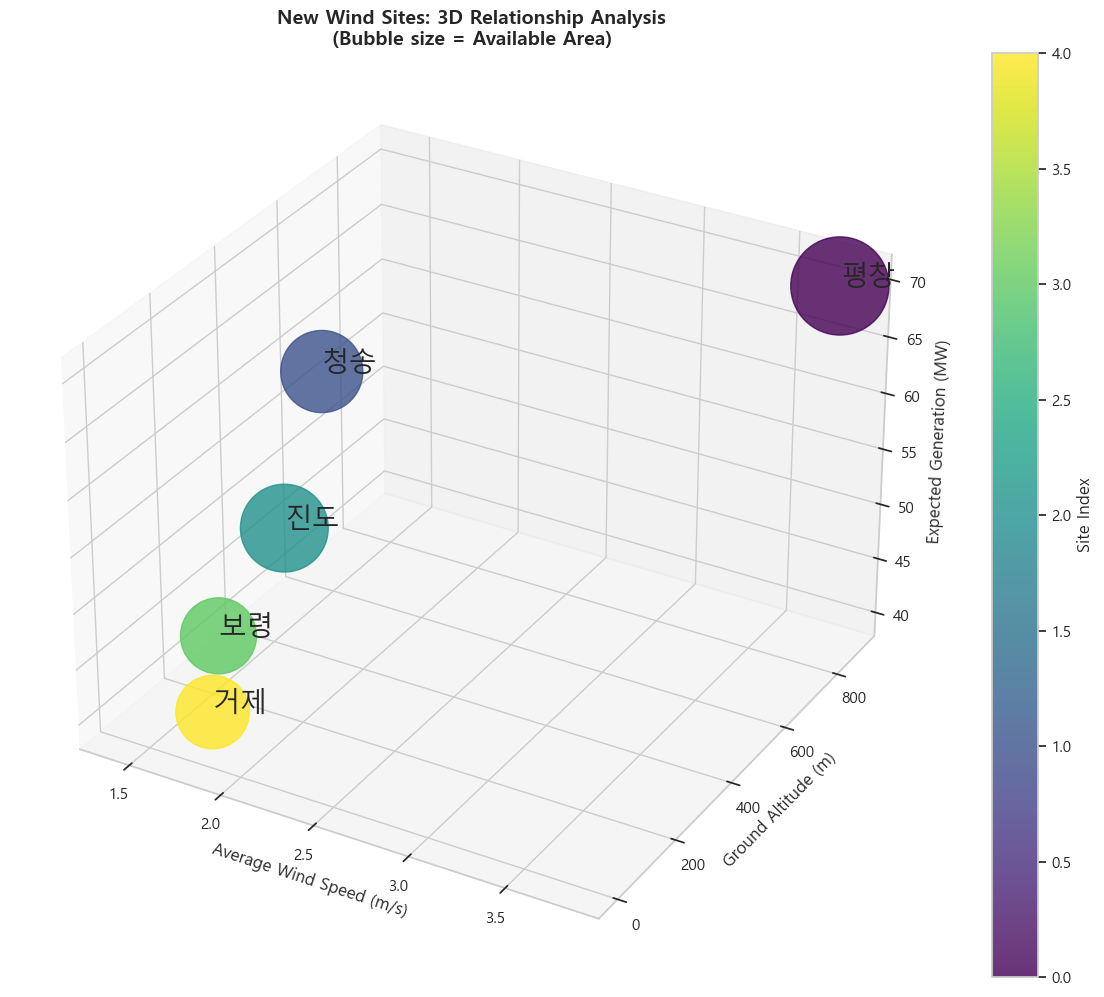

In [110]:

# 6. G. 3D 산점도 - 핵심 3요소 관계 분석
def create_3d_scatter(new_df):
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # 3D 산점도 (이용가능부지를 km²로 변환)
        area_km2 = new_df['available_area'] / 1000000  # m²를 km²로 변환
        scatter = ax.scatter(new_df['avg_wind_speed'], 
                        new_df['ground_altitude'], 
                        new_df['expected_generation'],
                        c=range(len(new_df)),
                        s=area_km2 * 10000,  # 점 크기는 이용가능부지 크기(km²)
                        cmap='viridis',
                        alpha=0.8)
        
        # 각 점에 라벨 추가
        for i, site in enumerate(new_df['site_name']):
                ax.text(new_df['avg_wind_speed'].iloc[i],
                        new_df['ground_altitude'].iloc[i],
                        new_df['expected_generation'].iloc[i],
                        site, fontsize=20)
                
                ax.set_xlabel('Average Wind Speed (m/s)')
                ax.set_ylabel('Ground Altitude (m)')
                ax.set_zlabel('Expected Generation (MW)')
                ax.set_title('New Wind Sites: 3D Relationship Analysis\n(Bubble size = Available Area)', size=14, weight='bold')
        
        plt.colorbar(scatter, ax=ax, label='Site Index')
        plt.tight_layout()
        plt.show()

create_3d_scatter(new_sites)

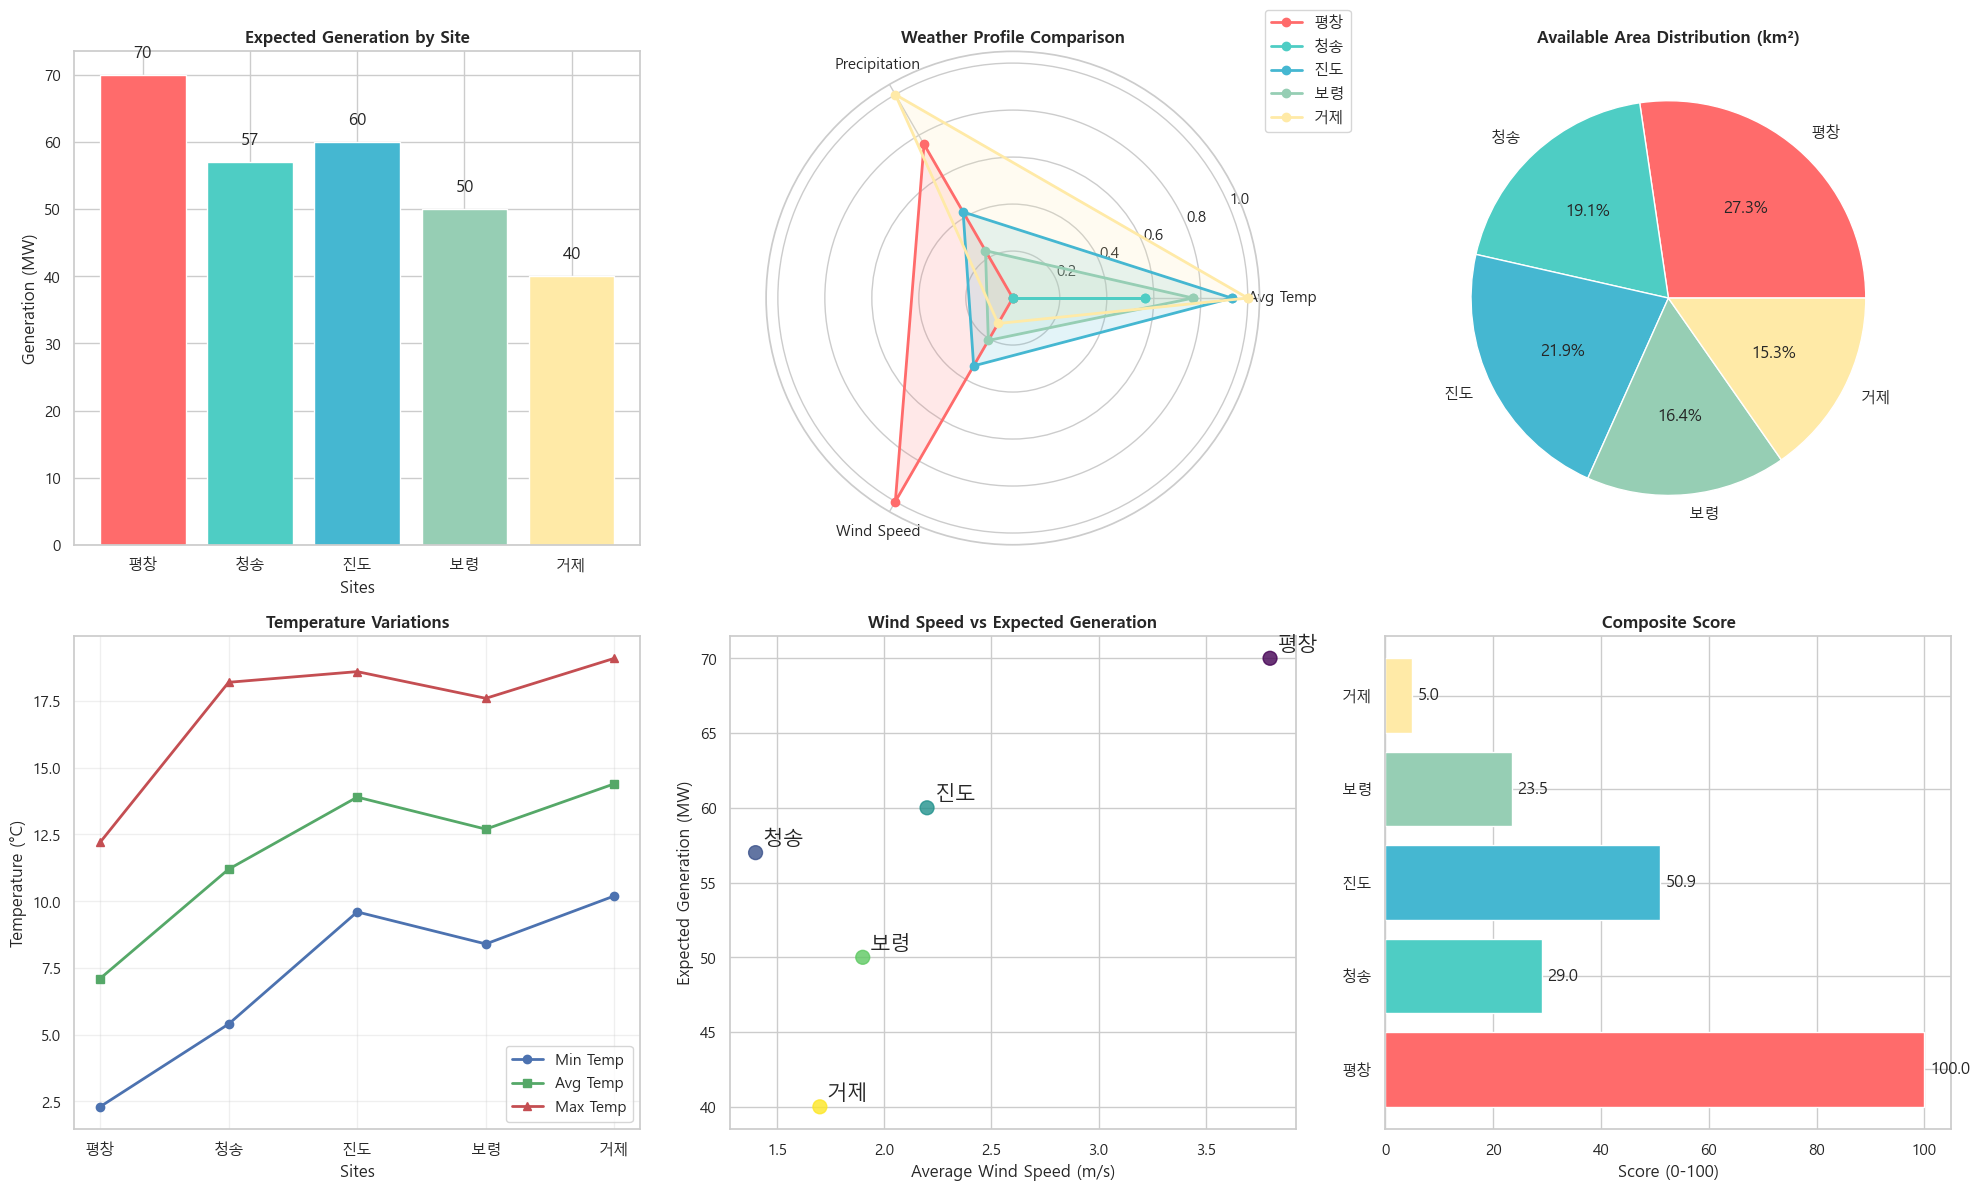

In [113]:

# H. 대시보드형 복합 차트

def create_dashboard(new_df):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    numeric_cols = [
        "expected_generation", 
        "available_area", 
        "avg_temp", 
        "max_temp", 
        "min_temp", 
        "avg_wind_speed", 
        "precipitation"
    ]
    
    # 숫자형 전처리
    for col in numeric_cols:
        if col in new_df.columns:
            new_df[col] = (
                new_df[col].astype(str)
                .str.replace(",", "", regex=False)
                .str.replace("㎡", "", regex=False)
                .str.replace("MW", "", regex=False)
                .str.replace("m/s", "", regex=False)
                .str.replace("℃", "", regex=False)
                .str.replace("m", "", regex=False)
                .str.strip()
            )
            new_df[col] = pd.to_numeric(new_df[col], errors="coerce")
    
    # 기본 색상
    base_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    ### 1. 예상발전량 바 차트
    ax1 = axes[0, 0]
    bars = ax1.bar(range(len(new_df)), new_df['expected_generation'].fillna(0), 
                    color=[base_colors[i % len(base_colors)] for i in range(len(new_df))])
    ax1.set_title('Expected Generation by Site', weight='bold')
    ax1.set_xlabel('Sites')
    ax1.set_ylabel('Generation (MW)')
    ax1.set_xticks(range(len(new_df)))
    ax1.set_xticklabels(new_df['site_name'])
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2, f'{height:.0f}', ha='center', va='bottom')
    
    # 2. 기상조건 레이더 차트 (모든 사이트)
    ax2 = axes[0, 1]
    ax2.remove()
    ax2 = fig.add_subplot(2, 3, 2, projection='polar')

    weather_metrics = ['avg_temp', 'precipitation', 'avg_wind_speed']  # humidity 제거
    weather_labels = ['Avg Temp', 'Precipitation', 'Wind Speed']

    angles = [n / float(len(weather_metrics)) * 2 * pi for n in range(len(weather_metrics))]
    angles += angles[:1]

    base_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

    for i in range(len(new_df)):
        weather_data = new_df[weather_metrics].iloc[i].fillna(0)
        weather_max = new_df[weather_metrics].max()
        weather_min = new_df[weather_metrics].min()
        # 0으로 나누는 오류 방지
        weather_norm = (weather_data - weather_min) / (weather_max - weather_min).replace(0, 1)
        
        values = weather_norm.values.tolist()
        values += values[:1]
        
        ax2.plot(angles, values, 'o-', linewidth=2, color=base_colors[i % len(base_colors)], label=new_df['site_name'].iloc[i])
        ax2.fill(angles, values, alpha=0.15, color=base_colors[i % len(base_colors)])

    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(weather_labels)
    ax2.set_title('Weather Profile Comparison', weight='bold')
    ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    
    ### 3. 부지조건 파이 차트
    ax3 = axes[0, 2]
    sizes = (new_df['available_area'] / 1_000_000)
    mask = sizes > 0
    if mask.sum() > 0:
        sizes_nonzero = sizes[mask]
        labels_nonzero = new_df['site_name'][mask]
        colors = [base_colors[i % len(base_colors)] for i in range(len(sizes_nonzero))]
        wedges, texts, autotexts = ax3.pie(
            sizes_nonzero,
            labels=labels_nonzero,
            autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
            colors=colors
        )
    else:
        ax3.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=14)
    ax3.set_title('Available Area Distribution (km²)', weight='bold')
    
    ### 4. 기온 변화 선 그래프
    ax4 = axes[1, 0]
    x_pos = range(len(new_df))
    ax4.plot(x_pos, new_df['min_temp'].fillna(0), 'b-o', label='Min Temp', linewidth=2)
    ax4.plot(x_pos, new_df['avg_temp'].fillna(0), 'g-s', label='Avg Temp', linewidth=2)
    ax4.plot(x_pos, new_df['max_temp'].fillna(0), 'r-^', label='Max Temp', linewidth=2)
    ax4.set_title('Temperature Variations', weight='bold')
    ax4.set_xlabel('Sites')
    ax4.set_ylabel('Temperature (°C)')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(new_df['site_name'])
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    ### 5. 풍속-발전량 산점도
    ax5 = axes[1, 1]
    scatter = ax5.scatter(new_df['avg_wind_speed'].fillna(0), new_df['expected_generation'].fillna(0),
                            s=100, c=range(len(new_df)), cmap='viridis', alpha=0.8)
    ax5.set_title('Wind Speed vs Expected Generation', weight='bold')
    ax5.set_xlabel('Average Wind Speed (m/s)')
    ax5.set_ylabel('Expected Generation (MW)')
    for i, site in enumerate(new_df['site_name']):
        ax5.annotate(site, (new_df['avg_wind_speed'].fillna(0).iloc[i], 
                            new_df['expected_generation'].fillna(0).iloc[i]),
                            xytext=(5, 5), textcoords='offset points', fontsize=15)
    
    ### 6. 종합점수 바 차트
    ax6 = axes[1, 2]
    area_km2 = (new_df['available_area'] / 1_000_000).fillna(0)
    weights = [0.4, 0.4, 0.2]
    scores = []
    
    for i in range(len(new_df)):
        gen_norm = (new_df['expected_generation'].iloc[i] - new_df['expected_generation'].min()) / \
                    (new_df['expected_generation'].max() - new_df['expected_generation'].min() or 1)
        wind_norm = (new_df['avg_wind_speed'].iloc[i] - new_df['avg_wind_speed'].min()) / \
                    (new_df['avg_wind_speed'].max() - new_df['avg_wind_speed'].min() or 1)
        area_norm = (area_km2.iloc[i] - area_km2.min()) / (area_km2.max() - area_km2.min() or 1)
        score = gen_norm * weights[0] + wind_norm * weights[1] + area_norm * weights[2]
        scores.append(score * 100)
    
    bars = ax6.barh(range(len(new_df)), scores, color=[base_colors[i % len(base_colors)] for i in range(len(new_df))])
    ax6.set_title('Composite Score', weight='bold')
    ax6.set_xlabel('Score (0-100)')
    ax6.set_yticks(range(len(new_df)))
    ax6.set_yticklabels(new_df['site_name'])
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax6.text(width + 1, bar.get_y() + bar.get_height()/2., f'{width:.1f}', ha='left', va='center')

    plt.tight_layout()
    plt.show()

create_dashboard(new_sites)
